In [ ]:
pip install pandas darts prophet

In [97]:
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mape
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [104]:
import pandas as pd

data = pd.read_excel('train.xlsx')

print(data.head())
print(data.columns)
print(data.isnull().sum())

        date  price
0 2015-01-05  32900
1 2015-01-12  32500
2 2015-01-19  32000
3 2015-01-26  30700
4 2015-02-02  30300
Index(['date', 'price'], dtype='object')
date     0
price    0
dtype: int64


In [115]:
data.rename(columns={'date': 'ds', 'price': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

In [68]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [118]:
from prophet import Prophet

model = Prophet()
model.fit(train)

09:40:08 - cmdstanpy - INFO - Chain [1] start processing
09:40:08 - cmdstanpy - INFO - Chain [1] done processing


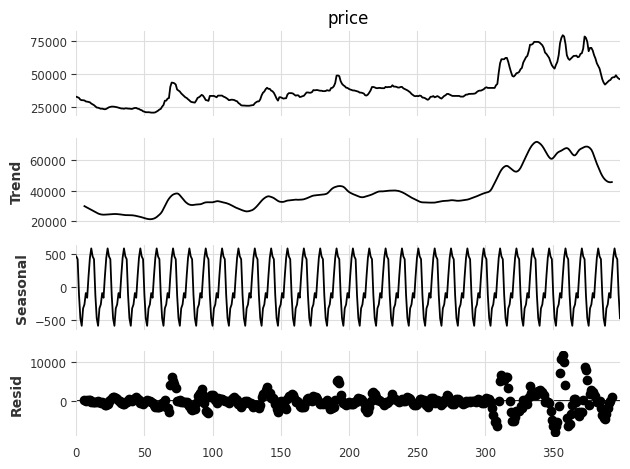

In [7]:
data.rename(columns={'y': 'price'}, inplace=True)
decomposition = seasonal_decompose(data['price'], model='additive', period=12)
decomposition.plot()
plt.show()

In [105]:
data.rename(columns={'price': 'y'}, inplace=True)


In [9]:
result = adfuller((data['y']))
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] <= 0.05:
    print("Ряд стационарен")
else:
    print("Ряд нестационарен")


ADF Statistic: -1.9258699893713453
p-value: 0.3199906102569917
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен


In [108]:
ts = data['y']
ts_log = np.log(ts)
ts_log_diff = ts_log.diff().dropna()
result = adfuller((data['y']))


In [110]:
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] <= 0.05:
    print("Ряд стационарен")
else:
    print("Ряд нестационарен")

Ряд стационарен


In [124]:
last_test_date = train['ds'].iloc[-1]

forecast = model.predict(test)

predicted = forecast['yhat'].iloc[-len(test):]
actual = test['y']

error_mape = mean_absolute_percentage_error(actual, predicted)
print(f'MAPE: {error_mape:.2f}%')
error_rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'RMSE: {error_rmse:.2f}')
error_mae = mean_absolute_error(actual, predicted)
print(f'MAE: {error_mae:.2f}')


MAPE: 1.00%
RMSE: 61467.62
MAE: 60598.66


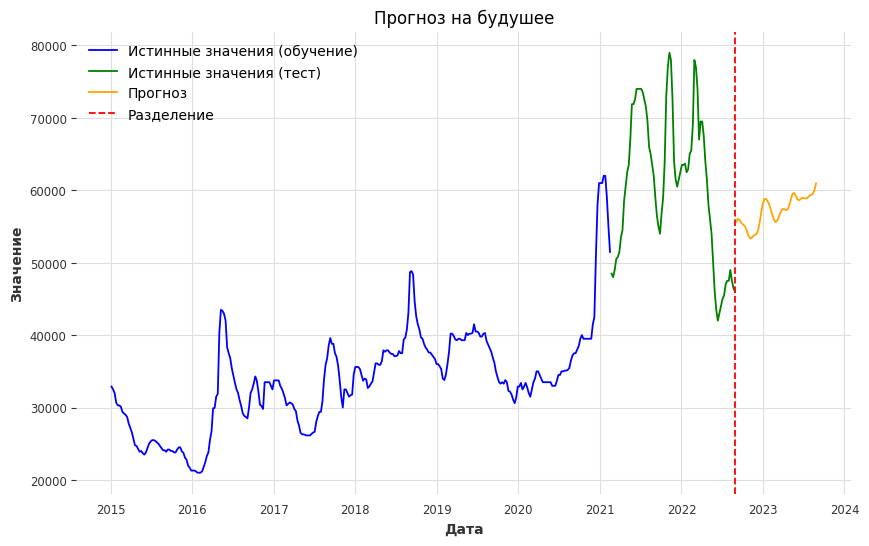

In [89]:
last_test_date = test['ds'].iloc[-1]

future_dates = pd.date_range(start=last_test_date, periods=52, freq='W')
future = pd.DataFrame({'ds': future_dates})

forecast = model.predict(future)

forecast.to_csv('forecast.csv', index=True)

plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Истинные значения (обучение)', color='blue')
plt.plot(test['ds'], test['y'], label='Истинные значения (тест)', color='green')
plt.plot(forecast['ds'], forecast['yhat'], label='Прогноз', color='orange')
plt.axvline(x=last_test_date, color='red', linestyle='--', label='Разделение')
plt.legend()
plt.title('Прогноз на будушее')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.show()